# 🎤 Speech Emotion Recognition Project

**Intern:** Ashna Imtiaz  
**Organization:** Code Alpha  
**Task:** Speech Emotion Recognition (SER)  

In [ ]:
!pip install pysoundfile -q

In [ ]:
import os
import pandas as pd

base_dir = '/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/'

file_paths, labels = [], []

for folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder)
    if os.path.isdir(folder_path):
        for filename in os.listdir(folder_path):
            if filename.lower().endswith('.wav'):
                emotion = folder.split('_')[-1].strip().lower()
                file_paths.append(os.path.join(folder_path, filename))
                labels.append(emotion)

data_df = pd.DataFrame({'file_path': file_paths, 'emotion': labels})

# Show dataset info
print(f"Total files: {len(data_df)}")
print(data_df['emotion'].value_counts().sort_index())
data_df.head()

Total files: 2800
emotion
angry        400
disgust      400
fear         400
happy        400
neutral      400
sad          400
surprise     200
surprised    200
Name: count, dtype: int64


,file_path,emotion
0,/kaggle/input/toronto-emotional-speech-set-tes...,fear
1,/kaggle/input/toronto-emotional-speech-set-tes...,fear
2,/kaggle/input/toronto-emotional-speech-set-tes...,fear
3,/kaggle/input/toronto-emotional-speech-set-tes...,fear
4,/kaggle/input/toronto-emotional-speech-set-tes...,fear


In [ ]:
# Assuming 'data_df' is your DataFrame with the 'emotion' column
data_df['emotion'] = data_df['emotion'].replace({'surprised': 'surprise'})

# Check the new value counts to confirm the fix
print(data_df['emotion'].value_counts().sort_index())

emotion
angry       400
disgust     400
fear        400
happy       400
neutral     400
sad         400
surprise    400
Name: count, dtype: int64


In [ ]:
import librosa
import numpy as np
from tqdm import tqdm  # progress bar

# List to store features
features = []

for file_path in tqdm(data_df['file_path'], desc="Extracting MFCCs"):
    # Load audio file
    y, sr = librosa.load(file_path, sr=16000)  # 16kHz sample rate

    # Extract MFCCs
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)  # 40 MFCC coefficients

    # Take the mean across time frames
    mfcc_mean = np.mean(mfcc.T, axis=0)

    features.append(mfcc_mean)

# Convert to NumPy array
X = np.array(features)

# Labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(data_df['emotion'])

print(f"Feature shape: {X.shape}")
print(f"Label shape: {y.shape}")


Extracting MFCCs: 100%|██████████| 2800/2800 [01:26<00:00, 32.34it/s]


Feature shape: (2800, 40)
Label shape: (2800,)


# Extract Featurs for CNN (no averaging)

In [ ]:
features_cnn = []

for file_path in tqdm(data_df['file_path'], desc="Extracting MFCCs for CNN"):
    y, sr = librosa.load(file_path, sr=16000)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)

    # Pad or truncate to fixed length (e.g., 173 frames for 3 sec at hop_length=512)
    max_len = 173
    if mfcc.shape[1] < max_len:
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0,0), (0,pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_len]

    features_cnn.append(mfcc)

X_cnn = np.array(features_cnn)
y_cnn = le.fit_transform(data_df['emotion'])

print(X_cnn.shape, y_cnn.shape)


Extracting MFCCs for CNN: 100%|██████████| 2800/2800 [00:47<00:00, 58.69it/s]

(2800, 40, 173) (2800,)


In [ ]:
# Add a channel dimension for CNN (grayscale image-like)
X_cnn = X_cnn[:, :, :, np.newaxis] # Shape: (2800, 40, 173, 1)
print(f"New shape for CNN: {X_cnn.shape}")

New shape for CNN: (2800, 40, 173, 1)


# Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_cnn, y_cnn, test_size=0.2, random_state=42, stratify=y_cnn
)


# Build CNN Model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

num_classes = len(np.unique(y_cnn))

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(40, 173, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


2025-08-09 15:03:05.166877: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754751785.404571      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754751785.480716      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-08-09 15:03:20.277182: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 38, 171, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 38, 171, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 19, 85, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 17, 83, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 17, 83, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 41, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 6, 39, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 6, 39, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 19, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 7296)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       934,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,028,487 (3.92 MB)

 Trainable params: 1,028,039 (3.92 MB)

 Non-trainable params: 448 (1.75 KB)

# Train the model on our data

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32
)


Epoch 1/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 25s 291ms/step - accuracy: 0.7255 - loss: 1.5334 - val_accuracy: 0.9571 - val_loss: 0.1496
Epoch 2/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 288ms/step - accuracy: 0.9901 - loss: 0.0236 - val_accuracy: 0.9804 - val_loss: 0.0687
Epoch 3/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 19s 265ms/step - accuracy: 0.9940 - loss: 0.0172 - val_accuracy: 0.9929 - val_loss: 0.0167
Epoch 4/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 22s 281ms/step - accuracy: 0.9948 - loss: 0.0149 - val_accuracy: 0.9946 - val_loss: 0.0100
Epoch 5/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 18s 264ms/step - accuracy: 0.9977 - loss: 0.0085 - val_accuracy: 0.9929 - val_loss: 0.0138
Epoch 6/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 18s 253ms/step - accuracy: 0.9995 - loss: 0.0069 - val_accuracy: 0.9982 - val_loss: 0.0045
Epoch 7/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 18s 257ms/step - accuracy: 0.9987 - loss: 0.0035 - val_accuracy: 0.9964 - val_loss: 0.0058
Epoch 8/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 18s 252ms/step - accuracy: 0.9962 - loss: 0.0108 - val_accu

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9950 - loss: 0.0091
Test Accuracy: 99.64%


In [ ]:
model.evaluate(X_test, y_test)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9950 - loss: 0.0091


[0.006156715098768473, 0.9964285492897034]

In [ ]:
import random
import IPython.display as ipd
import numpy as np
import librosa

# Pick a random sample from the dataset
random_idx = random.randint(0, len(data_df) - 1)
file_path = data_df.iloc[random_idx]['file_path']
true_label = data_df.iloc[random_idx]['emotion']

# Play the audio so you can hear it
print(f"Playing file: {file_path}")
ipd.display(ipd.Audio(file_path))

# Preprocess just like training
y, sr = librosa.load(file_path, sr=16000)
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)

max_len = 173
if mfcc.shape[1] < max_len:
    pad_width = max_len - mfcc.shape[1]
    mfcc = np.pad(mfcc, pad_width=((0,0), (0,pad_width)), mode='constant')
else:
    mfcc = mfcc[:, :max_len]

mfcc = mfcc[np.newaxis, ..., np.newaxis]  # Shape (1, 40, 173, 1)

# Predict
pred = model.predict(mfcc)
pred_label = le.inverse_transform([np.argmax(pred)])

print(f"True emotion: {true_label}")
print(f"Predicted emotion: {pred_label[0]}")


Playing file: /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_Fear/OAF_kite_fear.wav


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
True emotion: fear
Predicted emotion: fear


In [ ]:
import random
import IPython.display as ipd
import numpy as np
import librosa

# Choose the emotion you want to hear
target_emotion = "happy"  # change this to angry, sad, fear, etc.

# Filter dataset for that emotion
emotion_df = data_df[data_df['emotion'] == target_emotion]

# Pick a random file from that emotion
random_idx = random.randint(0, len(emotion_df) - 1)
file_path = emotion_df.iloc[random_idx]['file_path']
true_label = emotion_df.iloc[random_idx]['emotion']

# Play the audio
print(f"Playing {target_emotion} file: {file_path}")
ipd.display(ipd.Audio(file_path))

# Preprocess same as training
y, sr = librosa.load(file_path, sr=16000)
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)

max_len = 173
if mfcc.shape[1] < max_len:
    pad_width = max_len - mfcc.shape[1]
    mfcc = np.pad(mfcc, pad_width=((0,0), (0,pad_width)), mode='constant')
else:
    mfcc = mfcc[:, :max_len]

mfcc = mfcc[np.newaxis, ..., np.newaxis]  # Shape (1, 40, 173, 1)

# Predict with model
pred = model.predict(mfcc)
pred_label = le.inverse_transform([np.argmax(pred)])

print(f"True emotion: {true_label}")
print(f"Predicted emotion: {pred_label[0]}")


Playing happy file: /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_happy/OAF_mob_happy.wav


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
True emotion: happy
Predicted emotion: happy


In [ ]:
import random
import IPython.display as ipd
import numpy as np
import librosa

# Choose the emotion you want to hear
target_emotion = "surprise"  # change this to angry, sad, fear, etc.

# Filter dataset for that emotion
emotion_df = data_df[data_df['emotion'] == target_emotion]

# Pick a random file from that emotion
random_idx = random.randint(0, len(emotion_df) - 1)
file_path = emotion_df.iloc[random_idx]['file_path']
true_label = emotion_df.iloc[random_idx]['emotion']

# Play the audio
print(f"Playing {target_emotion} file: {file_path}")
ipd.display(ipd.Audio(file_path))

# Preprocess same as training
y, sr = librosa.load(file_path, sr=16000)
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)

max_len = 173
if mfcc.shape[1] < max_len:
    pad_width = max_len - mfcc.shape[1]
    mfcc = np.pad(mfcc, pad_width=((0,0), (0,pad_width)), mode='constant')
else:
    mfcc = mfcc[:, :max_len]

mfcc = mfcc[np.newaxis, ..., np.newaxis]  # Shape (1, 40, 173, 1)

# Predict with model
pred = model.predict(mfcc)
pred_label = le.inverse_transform([np.argmax(pred)])

print(f"True emotion: {true_label}")
print(f"Predicted emotion: {pred_label[0]}")


Playing surprise file: /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_Pleasant_surprise/OAF_talk_ps.wav


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
True emotion: surprise
Predicted emotion: surprise


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


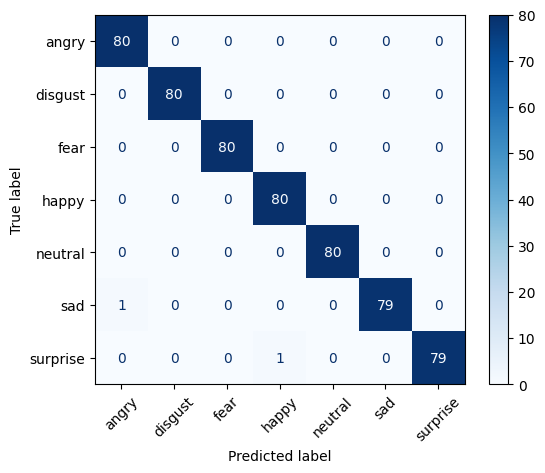

              precision    recall  f1-score   support

       angry       0.99      1.00      0.99        80
     disgust       1.00      1.00      1.00        80
        fear       1.00      1.00      1.00        80
       happy       0.99      1.00      0.99        80
     neutral       1.00      1.00      1.00        80
         sad       1.00      0.99      0.99        80
    surprise       1.00      0.99      0.99        80

    accuracy                           1.00       560
   macro avg       1.00      1.00      1.00       560
weighted avg       1.00      1.00      1.00       560



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# Predictions
y_pred_labels = np.argmax(model.predict(X_test), axis=1)

# If y_test is already integers:
y_true_labels = y_test

# Confusion Matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.show()

# Classification Report
print(classification_report(y_true_labels, y_pred_labels, target_names=le.classes_))


In [ ]:
import pickle

# 1. Save the trained CNN model
model.save("emotion_cnn.h5")  # HDF5 format

# 2. Save the label encoder
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

print("✅ Model and label encoder saved successfully!")


✅ Model and label encoder saved successfully!


In [ ]:
import shutil

shutil.move('emotion_cnn.h5', '/kaggle/working/emotion_cnn.h5')
shutil.move('label_encoder.pkl', '/kaggle/working/label_encoder.pkl')


'/kaggle/working/label_encoder.pkl'

In [ ]:
!ls /kaggle/working
emotion_cnn.h5	label_encoder.pkl

emotion_cnn.h5	label_encoder.pkl
